In [42]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')

from pyspark.sql import SparkSession
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from yellowbrick.model_selection import FeatureImportances
from pprint import pprint
import pandas as pd
from pyspark.ml.feature import VectorAssembler
import numpy as np
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [43]:
def mean(a_list):
    return sum(a_list)/len(a_list)

spark = SparkSession.builder.appName("dataMining").getOrCreate()
heart = spark.read.csv("prepared_heart_data.csv", header=True, inferSchema=True)
train = heart.filter(heart.partition == "train").drop("partition")
test = heart.filter(heart.partition == "test").drop("partition")

print(f"Train set observations: {train.count()}")
print(f"Train set observations: {test.count()}")

feature_columns = [col_name for col_name in train.columns if col_name != "target"]
target_column = "target"

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
train_assembled = assembler.transform(train)

Train set observations: 364
Train set observations: 83


In [44]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import seaborn as sns
import matplotlib.pyplot as plt

def accuracy_metrics(predictions):
    labels_and_predictions = predictions.select("target", "prediction")

    for column in labels_and_predictions.columns:
        labels_and_predictions = labels_and_predictions.withColumn(column, labels_and_predictions[column].cast('float'))

    metrics = MulticlassMetrics(labels_and_predictions.rdd)

    # Compute and display classification metrics
    accuracy = metrics.accuracy
    # I am extremely perplexed as to why, but the recall and precision values are swapped around by pyspark????
    # I did the manual calculations, and TP/(FP+TP) should be precision, but is pysparks "recall"
    # And also TP/(TP+FN) should be recall, but is pysparks "precision"
    recall = metrics.precision(label=1.0)
    precision = metrics.recall(label=1.0)
    auc = BinaryClassificationEvaluator(labelCol="target").evaluate(predictions)

    print("Test accuracy:", round(accuracy, 3))
    print("Recall score:", round(recall, 3))
    print("Precision score:", round(precision, 3))
    print("AUC score:", round(auc, 3))

    mat = metrics.confusionMatrix().toArray().transpose()

    sns.heatmap(mat, square=True, annot=True, fmt='.0f', cbar=False, xticklabels=True, yticklabels=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def print_tree(tree):
    print("Decision Tree Structure (Text Representation):")
    string_tree = str(tree.toDebugString)
    string_tree = string_tree[string_tree.find(", depth")+2:]
    for i in range(len(feature_columns)-1,-1,-1):
        string_tree = string_tree.replace(f"feature {i}", feature_columns[i])
    print(string_tree)


## Objective 1

In [46]:
from pyspark.ml.classification import LogisticRegression

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
train_assembled = assembler.transform(train)

lr = LogisticRegression(featuresCol="features", labelCol="target", maxIter=10000)

paramGrid = (
    ParamGridBuilder()
    .addGrid(lr.regParam, [0, 0.01, 0.03, 0.1, 1.0])
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
    .addGrid(lr.fitIntercept, [True, False])
    .addGrid(lr.standardization, [True, False])
    .build()
)

evaluator = BinaryClassificationEvaluator(labelCol="target")

cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10, seed=722)

cvModel = cv.fit(train_assembled)

# Print best hyperparameters
print("Best params:")
print(f"Regularization Param: {cvModel.bestModel.getRegParam()}")
print(f"Elastic Net Param: {cvModel.bestModel.getElasticNetParam()}")
print(f"Fit Intercept: {cvModel.bestModel.getFitIntercept()}")
print(f"Standardization: {cvModel.bestModel.getStandardization()}")

# Print train accuracy
print(f"Train Accuracy: {cvModel.avgMetrics[0]:.3f}")

# Evaluate on test data
test_assembled = assembler.transform(test)
predictions = cvModel.bestModel.transform(test_assembled)

Best params:
Regularization Param: 0.03
Elastic Net Param: 0.0
Fit Intercept: True
Standardization: True
Train Accuracy: 0.942


/Users/stephen/Library/Python/3.9/lib/python/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Test accuracy: 0.771
Recall score: 0.804
Precision score: 0.787
AUC score: 0.867


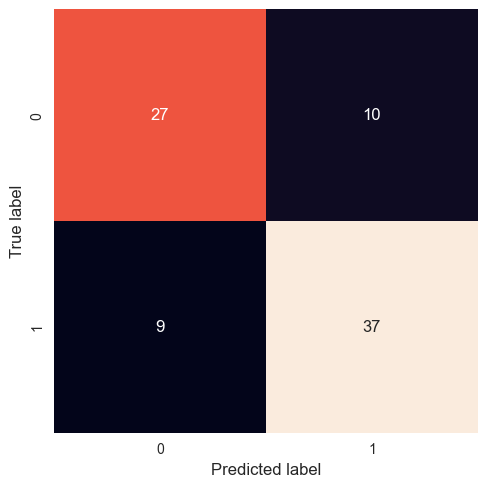

                           Coefficient     Value
0   thalassemia_type_reversible_defect -1.544103
1                     vessels_coloured -0.942043
2              exercise_induced_angina -0.897877
3         chest_pain_type_asymptomatic -0.860955
4                                  sex -0.622108
5                    num_major_vessels -0.583086
6           resting_blood_pressure_log -0.517404
7                        st_depression -0.245686
8               resting_blood_pressure -0.012484
9              max_heart_rate_achieved  0.010650
10                       rest_ecg_type  0.727957
11             st_slope_type_upsloping  0.929738
12    chest_pain_type_non-anginal_pain  0.972688
13                           intercept  3.888024


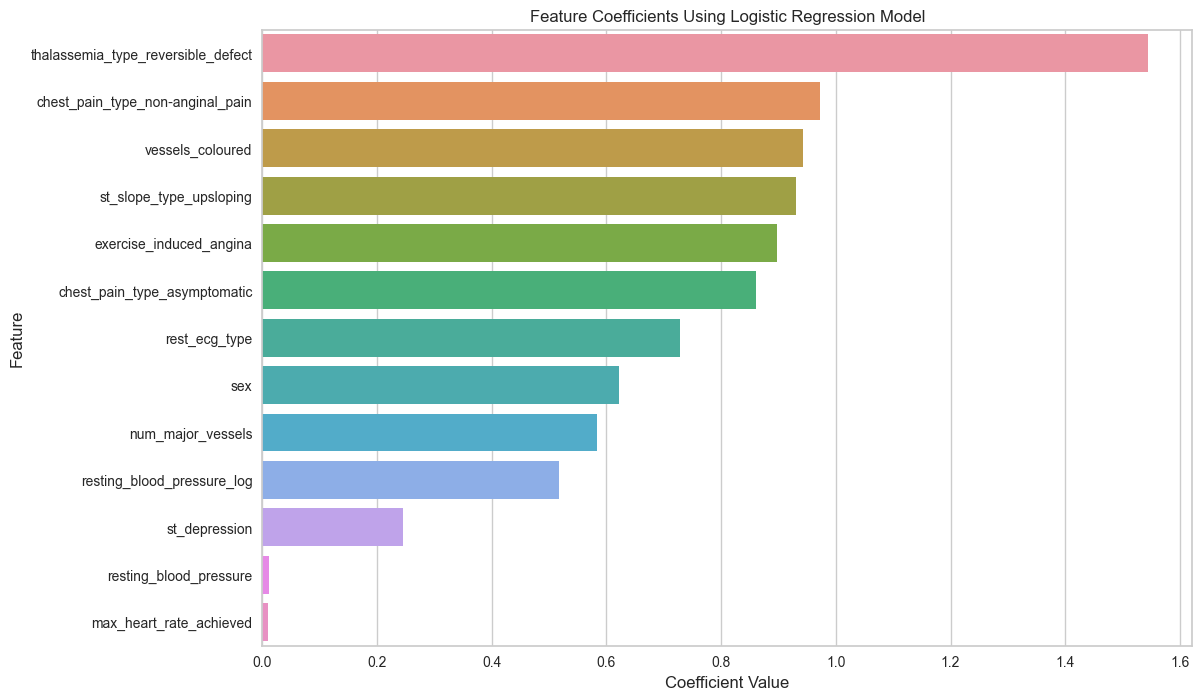

In [47]:
accuracy_metrics(predictions)

coefficients = cvModel.bestModel.coefficients.toArray()

coef_scores = sorted(list(zip(feature_columns, coefficients)) + [("intercept", cvModel.bestModel.intercept)], key=lambda x: x[1])

coef_values = pd.DataFrame.from_records(coef_scores, columns = ["Coefficient", "Value"])
print(coef_values)

coef_values["Importance"] = abs(coef_values["Value"])

plt.figure(figsize=(12, 8))
sns.barplot(y="Coefficient", x="Importance", data=coef_values.sort_values("Importance", ascending=False).iloc[1:,])
plt.title("Feature Coefficients Using Logistic Regression Model")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()

cvModel.bestModel.save("logistic_model")

### Decision tree

In [48]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol="features", labelCol="target")

paramGrid = (
    ParamGridBuilder()
    .addGrid(dt.impurity, ["gini", "entropy"])
    .addGrid(dt.maxDepth, list(range(1, 5)))
    .addGrid(dt.minInstancesPerNode, list(np.cumprod([2] * 4)))
    .build()
)

evaluator = BinaryClassificationEvaluator(labelCol="target")

cv = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10, seed=722)

cvModel = cv.fit(train_assembled)

# Print best hyperparameters
print("Best params:")
print(f"Impurity: {cvModel.bestModel.getImpurity()}")
print(f"Max Depth: {cvModel.bestModel.getMaxDepth()}")
print(f"Min Instances Per Node: {cvModel.bestModel.getMinInstancesPerNode()}")
print(f"Min Info Gain: {cvModel.bestModel.getMinInfoGain()}")

# Print train accuracy
print(f"Train Accuracy: {cvModel.avgMetrics[0]:.3f}")

# Evaluate on test data
test_assembled = assembler.transform(test)
predictions = cvModel.bestModel.transform(test_assembled)

dt_model = cvModel.bestModel


Best params:
Impurity: gini
Max Depth: 4
Min Instances Per Node: 8
Min Info Gain: 0.0
Train Accuracy: 0.764


Decision Tree Structure (Text Representation):
depth=4, numNodes=17, numClasses=2, numFeatures=13
  If (chest_pain_type_asymptomatic <= 0.5)
   If (thalassemia_type_reversible_defect <= 0.5)
    If (num_major_vessels <= 1.5)
     Predict: 1.0
    Else (num_major_vessels > 1.5)
     If (max_heart_rate_achieved <= 152.5)
      Predict: 0.0
     Else (max_heart_rate_achieved > 152.5)
      Predict: 1.0
   Else (thalassemia_type_reversible_defect > 0.5)
    If (st_slope_type_upsloping <= 0.5)
     Predict: 0.0
    Else (st_slope_type_upsloping > 0.5)
     Predict: 1.0
  Else (chest_pain_type_asymptomatic > 0.5)
   If (num_major_vessels <= 0.5)
    If (exercise_induced_angina <= 0.5)
     If (thalassemia_type_reversible_defect <= 0.5)
      Predict: 1.0
     Else (thalassemia_type_reversible_defect > 0.5)
      Predict: 0.0
    Else (exercise_induced_angina > 0.5)
     Predict: 0.0
   Else (num_major_vessels > 0.5)
    Predict: 0.0



/Users/stephen/Library/Python/3.9/lib/python/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Test accuracy: 0.771
Recall score: 0.761
Precision score: 0.814
AUC score: 0.809


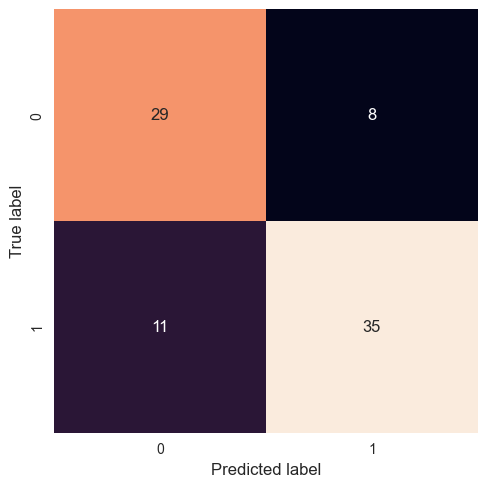

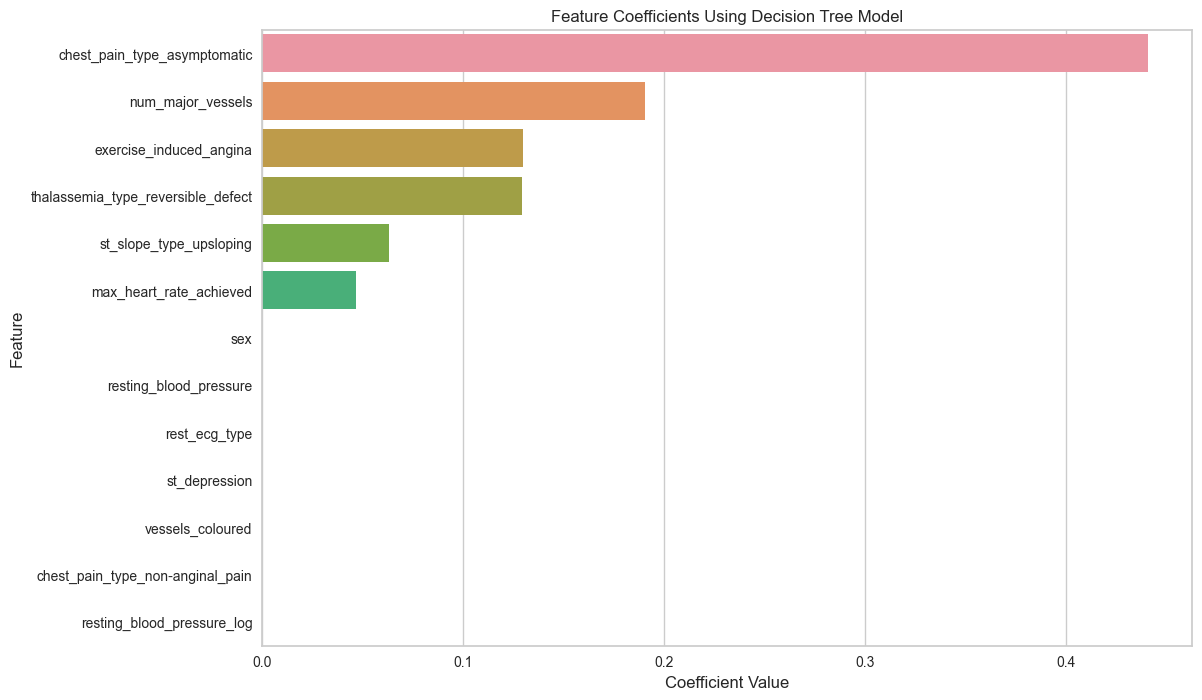

In [49]:
print_tree(dt_model)

accuracy_metrics(predictions)

coefficients = dt_model.featureImportances.toArray()
coef_scores = sorted(list(zip(feature_columns, coefficients)), key=lambda x: x[1], reverse=True)

feature_importance = pd.DataFrame.from_records(coef_scores, columns = ["Coefficient", "Importance"])

plt.figure(figsize=(12, 8))
sns.barplot(y="Coefficient", x="Importance", data=feature_importance)
plt.title("Feature Coefficients Using Decision Tree Model")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()

cvModel.bestModel.save("dt_model")

## Objective 2

23/10/11 22:56:48 WARN DAGScheduler: Broadcasting large task binary with size 1147.7 KiB
23/10/11 22:56:49 WARN DAGScheduler: Broadcasting large task binary with size 1390.7 KiB
23/10/11 22:56:50 WARN DAGScheduler: Broadcasting large task binary with size 1121.6 KiB
23/10/11 22:56:50 WARN DAGScheduler: Broadcasting large task binary with size 1348.5 KiB
23/10/11 22:56:51 WARN DAGScheduler: Broadcasting large task binary with size 1147.7 KiB
23/10/11 22:56:51 WARN DAGScheduler: Broadcasting large task binary with size 1390.7 KiB
23/10/11 22:56:52 WARN DAGScheduler: Broadcasting large task binary with size 1121.6 KiB
23/10/11 22:56:52 WARN DAGScheduler: Broadcasting large task binary with size 1348.5 KiB
23/10/11 22:56:53 WARN DAGScheduler: Broadcasting large task binary with size 1147.7 KiB
23/10/11 22:56:53 WARN DAGScheduler: Broadcasting large task binary with size 1390.7 KiB
23/10/11 22:56:54 WARN DAGScheduler: Broadcasting large task binary with size 1121.6 KiB
23/10/11 22:56:55 WAR

Best params:
Number of Trees: 400
Feature Subset Strategy: auto
Impurity: entropy
Train Accuracy: 0.872


/Users/stephen/Library/Python/3.9/lib/python/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
23/10/11 23:03:53 WARN DAGScheduler: Broadcasting large task binary with size 1803.6 KiB
23/10/11 23:03:53 WARN DAGScheduler: Broadcasting large task binary with size 1816.1 KiB


Test accuracy: 0.795
Recall score: 0.804
Precision score: 0.822
AUC score: 0.88


23/10/11 23:03:54 WARN DAGScheduler: Broadcasting large task binary with size 1813.2 KiB


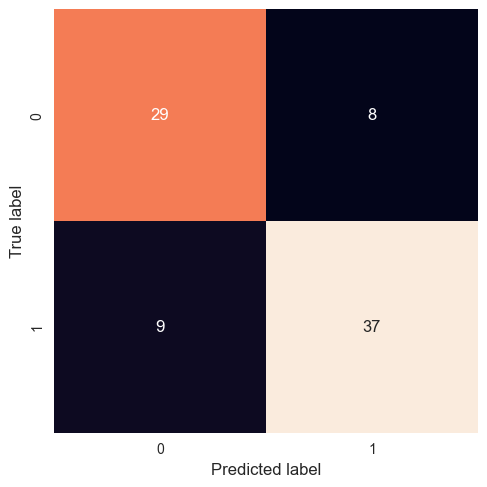

In [50]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol="features", labelCol="target", seed=722)

paramGrid = (
    ParamGridBuilder()
    .addGrid(rf.numTrees, [300, 400, 500, 1000])
    .addGrid(rf.featureSubsetStrategy, ["auto", "sqrt", "log2"])
    .addGrid(rf.impurity, ["gini", "entropy"])
    .build()
)

evaluator = BinaryClassificationEvaluator(labelCol="target",rawPredictionCol="prediction", metricName="areaUnderROC")

cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10, seed=722)

cvModel = cv.fit(train_assembled)

# Print best hyperparameters
print("Best params:")
print(f"Number of Trees: {cvModel.bestModel._java_obj.getNumTrees()}")
print(f"Feature Subset Strategy: {cvModel.bestModel._java_obj.getFeatureSubsetStrategy()}")
print(f"Impurity: {cvModel.bestModel._java_obj.getImpurity()}")

# Print train accuracy
print(f"Train Accuracy: {cvModel.avgMetrics[0]:.3f}")

# Evaluate on test data
test_assembled = assembler.transform(test)
predictions = cvModel.bestModel.transform(test_assembled)

accuracy_metrics(predictions)

cvModel.bestModel.save("rf_model")

Best params:
Max Depth: 5
Max Bins: 64
Step Size: 0.1
Train Accuracy: 0.867
Test accuracy: 0.795
Recall score: 0.804
Precision score: 0.822
AUC score: 0.86


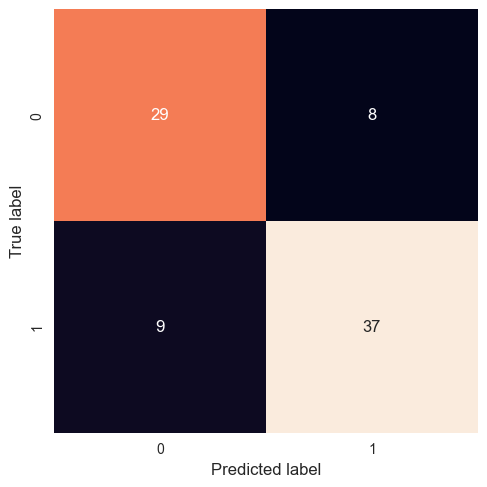

23/10/12 01:44:06 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1004757 ms exceeds timeout 120000 ms
23/10/12 01:44:06 WARN SparkContext: Killing executors is not supported by current scheduler.
23/10/12 01:44:10 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$

In [51]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(featuresCol="features", labelCol="target", seed=722)

paramGrid = (
    ParamGridBuilder()
    .addGrid(gbt.maxDepth, [3, 4, 5, 6])
    .addGrid(gbt.maxBins, [32, 64])
    .addGrid(gbt.stepSize, [0.05, 0.1, 0.15])
    .build()
)

evaluator = BinaryClassificationEvaluator(labelCol="target",rawPredictionCol="prediction", metricName="areaUnderROC")

cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10, seed=722)

cvModel = cv.fit(train_assembled)

# Print best hyperparameters
print("Best params:")
print(f"Max Depth: {cvModel.bestModel.getMaxDepth()}")
print(f"Max Bins: {cvModel.bestModel.getMaxBins()}")
print(f"Step Size: {cvModel.bestModel.getStepSize()}")

# Print train accuracy
print(f"Train Accuracy: {cvModel.avgMetrics[0]:.3f}")

# Evaluate on test data
test_assembled = assembler.transform(test)
predictions = cvModel.bestModel.transform(test_assembled,)

# Print accuracy and other metrics
accuracy_metrics(predictions)

cvModel.bestModel.save("GBT_model")